# Data Wrangling

In this notebook we will create the following datasets:

    - Terrorism related search queries [2012-01-01 -> 2014-08-31] US geolocalisation
    - Domestic related search queries [2012-01-01 -> 2014-08-31] US geolocalisation
    - top 30 MTurk evaluation terrorism related search queries [2012-01-01 -> 2014-08-31] US geolocalisation
    - Terrorism related search queries [2012-01-01 -> 2020-11-30] US geolocalisation
    - Domestic related search queries [2012-01-01 -> 2020-11-30] US geolocalisation
    - top 30 MTurk evaluation terrorism related search queries [2012-01-01 -> 2020-11-30] US geolocalisation


### Imports

In [1]:
!pip install gtab
import gtab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Directory to save data
data_path = "data/"

### Create and set GoogleTrendsAnchorBank for queries

In [3]:
def create_and_set_gtab(start_timeframe, end_timeframe, geo, gtab_path = "gtab_data"):
    """Creates and sets a gtab to the required options.
    This functions takes a lot of time if the anchorbank was not yet created.
    It also creates a directory if needed to the gtab_path

    Args:
        start_timeframe (str): start of the timeframe for the queries (included)
        end_timeframe (str): end of the timeframe for the queries (included)
        geo (str): geolocalisation of the search query
        gtab_path (str): path to already existing data

    Returns:
        t (GTAB): GoogleTrendsAnchorBank to use for the queries, consistent with the provided options

    """
    t = gtab.GTAB(dir_path=gtab_path)
    # Create time frame
    timeframe = start_timeframe + " " + end_timeframe
    
    # Set required options
    t.set_options(pytrends_config={"geo": geo, "timeframe": timeframe})  
    
    # Create anchorbank if it doesn't already exist
    t.create_anchorbank() # takes a while to run since it queries Google Trends. 
    
    # We apply the anchorbank
    t.set_active_gtab(f"google_anchorbank_geo={geo}_timeframe={timeframe}.tsv")
    
    return t

In [4]:
#TODO: should we include until present time for an extended analysis?
# Create time frame corresponding to the paper study
start_timeframe = "2012-01-01"
end_timeframe   = "2014-08-31" #TODO: si cest borne inclu (ca a l'air detre le cas) sinon =>"2014-09-01"
timeframe = start_timeframe + " " + end_timeframe

# We choose the US geolocalisation because categories are from the DHS
geo = "US" # empty string corresponds to worldwide

t = create_and_set_gtab(start_timeframe, end_timeframe, geo)

Directory already exists, loading data from it.
Using directory 'gtab_data'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Start AnchorBank init for region US in timeframe 2012-01-01 2014-08-31...
GTAB with such parameters already exists! Load it with 'set_active_gtab(filename)' or rename/delete it to create another one with this name.
Active anchorbank changed to: google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv



## Create paper timeframe dataframes

In [5]:
def create_dataframe(domain_name, geo, t):
    """Creates a dataframe concatenating all search queries interest over time data from google
    trends for one domain. The search queries will use the corresponding topics to the DHS category for the domain.
    Prints parametters of queries who failed.
    The returned dataframe has attributes:
    {date, max_ratio, max_ratio_hi, max_ratio_l, article_name, topic_name, topic_id, geo}

    Args:
        domain_name (str): domain of the search queries (ie. terrorims, domestic, top_30_terrorism)       
        geo (str): geolocalisation of the search query
        t (GTAB): GoogleTrendsAnchorBank to use for the queries it needs to be consistent with the geo parameter

    Returns:
        dataframe: dataframe concatenating all search queries interest over time data from google
    trends

    """
    mapping_df = pd.read_pickle(data_path+"mapping.pkl")
    
    # Get the list of the article names of this domain 
    topic_queries_articles = mapping_df[mapping_df["domain_name"] == domain_name]["search_term"].tolist()
    # Get the list of topic ids of this domain 
    topic_queries_ids = mapping_df[mapping_df["domain_name"] == domain_name]["entity_id"].tolist()
    # Get the list of topic names of this domain 
    topic_queries_name = mapping_df[mapping_df["domain_name"] == domain_name]["entity_name"].tolist()
    
    # For each search query freebase id create the corresponding interest over time google trends data
    all_interest_over_time_dfs = [t.new_query(search_query) for search_query in topic_queries_ids]
    
    # Find all queries who succeeded                 
    successful_queries = [type(df) != type(-1) for df in all_interest_over_time_dfs]
    
    df_to_concatenate = []
    # Append the name and location to all dataframes
    for i, df in enumerate(all_interest_over_time_dfs):
        
        # Was it a successful query
        if successful_queries[i]:
            
            # Add the article name collumn 
            df["article_name"] = [topic_queries_articles[i]]*len(df)
            # Add the topic name collumn 
            df["topic_id"] = [topic_queries_ids[i]]*len(df)
            # Add the topic id collumn 
            df["topic_name"] = [topic_queries_name[i]]*len(df)
            # Add the localisation collumn
            df["geo"] = ["worldwide" if geo == "" else geo]*len(df)
            
            df_to_concatenate.append(df)
            
        # If not we print the parametters that failed
        else:
            print("Found a failed query")
            print(f"Article name: {topic_queries_articles[i]}")
            print(f"Topic name: {topic_queries_name[i]}")
            print(f"Topic id: {topic_queries_ids[i]}")
    
    # Concatenate all dfs into one centrale one
    return pd.concat(df_to_concatenate).reset_index()

In [6]:
def get_topics(domain_name, data_path):
    """Gives the list of all topics corresponding to the search queries for the specific domain.
    
    Args:
         domain_name (str): domain name of the search queries (i.e: terrorism, domestic, top_30_terrorism)
         data_path (str): directory path containing the mapping pickle file 
    
    Returns:
        list of all topics for this domain
    """
    
    mapping_df = pd.read_pickle(data_path+"mapping.pkl")
    
    return mapping_df[mapping_df["domain_name"] == domain_name]["entity_id"].tolist()

### Terrorism dataset

Terrorism related search queries [2012-01-01 -> 2014-08-31] US geolocalisation

In [7]:
# Create terrorism dataframe
terrorism_df = create_dataframe("terrorism", geo, t)


Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0v74'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/07jq_'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/g/11bc5q9v7r'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0d05q4'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0jdd'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/03shp'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/05s

In [8]:
# View of created df
terrorism_df.head()

,date,max_ratio,max_ratio_hi,max_ratio_lo,article_name,topic_id,topic_name,geo
0,2012-01-01,1.033386,1.104069,0.966184,Al-Qaeda,/m/0v74,Al-Qaeda,US
1,2012-01-08,1.192369,1.267634,1.120773,Al-Qaeda,/m/0v74,Al-Qaeda,US
2,2012-01-15,1.271860,1.349417,1.198068,Al-Qaeda,/m/0v74,Al-Qaeda,US
3,2012-01-22,1.192369,1.267634,1.120773,Al-Qaeda,/m/0v74,Al-Qaeda,US
4,2012-01-29,1.192369,1.267634,1.120773,Al-Qaeda,/m/0v74,Al-Qaeda,US


In [9]:
# Save dataframe to pickle
terrorism_df.to_pickle(data_path+"terrorism.pkl")

### Domestic dataset

Domestic related search queries [2012-01-01 -> 2014-08-31] US geolocalisation

In [10]:
# Create domestic dataframe
domestic_df = create_dataframe("domestic", geo, t)

Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0fytk'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0js8z'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/07xhy'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/038r8p'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/02qtlv'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0fynw'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0f4r5

In [11]:
# View of created df
domestic_df.head()

,date,max_ratio,max_ratio_hi,max_ratio_lo,article_name,topic_id,topic_name,geo
0,2012-01-01,3.974563,4.130035,3.826087,Department of Homeland Security,/m/0fytk,United States Department of Homeland Security,US
1,2012-01-08,4.531002,4.702515,4.367150,Department of Homeland Security,/m/0fytk,United States Department of Homeland Security,US
2,2012-01-15,4.133545,4.293600,3.980676,Department of Homeland Security,/m/0fytk,United States Department of Homeland Security,US
3,2012-01-22,4.292528,4.457166,4.135266,Department of Homeland Security,/m/0fytk,United States Department of Homeland Security,US
4,2012-01-29,4.133545,4.293600,3.980676,Department of Homeland Security,/m/0fytk,United States Department of Homeland Security,US


In [12]:
# Save dataframe to pickle
domestic_df.to_pickle(data_path+"domestic.pkl")

### Top 30 Terrorism dataset

top 30 MTurk evaluation terrorism related search queries [2012-01-01 -> 2014-08-31] US geolocalisation

In [13]:
# Create top-30 terrorism dataframe
top_30_terrorism_df = create_dataframe("top_30_terrorism", geo, t)

Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0v74'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/07jq_'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/02w1mcd'

Bad keyword '/m/02w1mcd', because The request failed: Google returned a response with code 400.
Keyword /m/02w1mcd is bad!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/01s60b'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/02t93h'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0blqm8'
New query calibrated!
Using gtab_data/ou

In [14]:
# View of created df
top_30_terrorism_df.head()

,date,max_ratio,max_ratio_hi,max_ratio_lo,article_name,topic_id,topic_name,geo
0,2012-01-01,1.033386,1.104069,0.966184,Al Qaeda,/m/0v74,Al-Qaeda,US
1,2012-01-08,1.192369,1.267634,1.120773,Al Qaeda,/m/0v74,Al-Qaeda,US
2,2012-01-15,1.271860,1.349417,1.198068,Al Qaeda,/m/0v74,Al-Qaeda,US
3,2012-01-22,1.192369,1.267634,1.120773,Al Qaeda,/m/0v74,Al-Qaeda,US
4,2012-01-29,1.192369,1.267634,1.120773,Al Qaeda,/m/0v74,Al-Qaeda,US


In [15]:
# Save dataframe to pickle
top_30_terrorism_df.to_pickle(data_path+"top_30_terrorism.pkl")

## Create present timeframe dataframes

In [16]:
# Set start to paper start timeframe and end to present time (Stop at November 2020)
start_timeframe = "2012-01-01"
end_timeframe   = "2020-11-30"
timeframe = start_timeframe + " " + end_timeframe

# We choose the US geolocalisation because categories are from the DHS
geo = "US" # empty string corresponds to worldwide

t = create_and_set_gtab(start_timeframe, end_timeframe, geo)

Directory already exists, loading data from it.
Using directory 'gtab_data'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Start AnchorBank init for region US in timeframe 2012-01-01 2020-11-30...
GTAB with such parameters already exists! Load it with 'set_active_gtab(filename)' or rename/delete it to create another one with this name.
Active anchorbank changed to: google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv



### Terrorism dataset

Terrorism related search queries [2012-01-01 -> 2020-11-30] US geolocalisation

In [17]:
# Create terrorism dataframe
terrorism_df = create_dataframe("terrorism", geo, t)

Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0v74'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/07jq_'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/g/11bc5q9v7r'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0d05q4'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0jdd'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/03shp'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/05s

In [18]:
# Save dataframe to pickle
terrorism_df.to_pickle(data_path+"terrorism_present.pkl")

### Domestic dataset

Domestic related search queries [2012-01-01 -> 2020-11-30] US geolocalisation

In [19]:
# Create domestic dataframe
domestic_df = create_dataframe("domestic", geo, t)

Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0fytk'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0js8z'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/07xhy'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/038r8p'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/02qtlv'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0fynw'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0f4r5

In [20]:
# Save dataframe to pickle
domestic_df.to_pickle(data_path+"domestic_present.pkl")

### Top 30 Terrorism dataset

top 30 MTurk evaluation terrorism related search queries [2012-01-01 -> 2020-11-30] US geolocalisation

In [21]:
# Create top-30 terrorism dataframe
top_30_terrorism_df = create_dataframe("top_30_terrorism", geo, t)

Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0v74'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/07jq_'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/02w1mcd'

Bad keyword '/m/02w1mcd', because The request failed: Google returned a response with code 400.
Keyword /m/02w1mcd is bad!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/01s60b'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/02t93h'
New query calibrated!
Using gtab_data/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2012-01-01 2020-11-30.tsv
New query '/m/0blqm8'
New query calibrated!
Using gtab_data/ou

In [4]:
# Save dataframe to pickle
top_30_terrorism_df.to_pickle(data_path+"top_30_terrorism_present.pkl")

NameError: name 'top_30_terrorism_df' is not defined

Directory already exists, loading data from it.
Using directory 'gtab_data'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv

Start AnchorBank init for region US in timeframe 2012-01-01 2014-08-31...
GTAB with such parameters already exists! Load it with 'set_active_gtab(filename)' or rename/delete it to create another one with this name.
Active anchorbank changed to: google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv

Using gtab_data\output\google_anchorbanks\google_anchorbank_geo=US_timeframe=2012-01-01 2014-08-31.tsv
New query '/m/0vzv0rq'
	Query: '/m/0vzv0rq'	Anchor:'/m/01qt9r'
	Query: '/m/0vzv0rq'	Anchor:'Instagram'
	Query: '/m/0vzv0rq'	Anchor:'/m/0cyhj_'
New query calibrated!


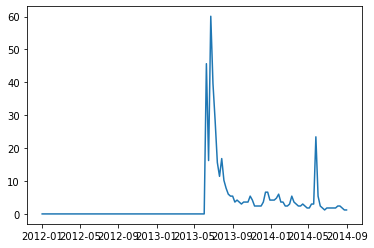

In [8]:
import matplotlib.pyplot as plt
start_timeframe = "2012-01-01"
end_timeframe   = "2014-08-31" #TODO: si cest borne inclu (ca a l'air detre le cas) sinon =>"2014-09-01"
timeframe = start_timeframe + " " + end_timeframe

# We choose the US geolocalisation because categories are from the DHS
geo = "US" # empty string corresponds to worldwide

t = create_and_set_gtab(start_timeframe, end_timeframe, geo)

# Found topic by using google trends with the topic: Edward Snowden 
snowden_topic = "/m/0vzv0rq"
snowden_topic_query = t.new_query(snowden_topic)

plt.plot(snowden_topic_query.max_ratio)